In [ ]:
import pandas as pd
from transformers import pipeline

# 1. Read your CSV into a DataFrame
df = pd.read_csv("/content/faq_data.csv")

# 2. Identify your label candidates
#    - If you already have a known set of possible labels, specify them here.
#      For example, let's say your dataset typically has these 5 categories:
candidate_labels = ["LabelA", "LabelB", "LabelC", "LabelD", "LabelE"]

# 3. Load a zero-shot classification pipeline from gemma2‑9b
#    (Replace "myorg/gemma2-9b" with the actual model identifier or local path.)
classifier = pipeline(
    task="zero-shot-classification",
    model="google/gemma-2-9b-it",  # hypothetical: replace with real ID or local checkpoint
    device="cuda:0"          # or "cpu" if you don't have GPU
)

# 4. Create a new column for corrected labels
corrected_labels = []

for idx, row in df.iterrows():
    question_text = str(row["question"])
    existing_label = str(row["button"]).strip()

    # If the label is missing or obviously invalid, we re-label:
    if existing_label == "" or existing_label.lower() in ["nan", "none", "null"]:
        # Zero-shot classification call:
        result = classifier(question_text, candidate_labels)
        # The pipeline returns a dict with keys like "labels" and "scores".
        # We pick the label with the highest score:
        best_label = result["labels"][0]
        corrected_labels.append(best_label)
    else:
        # If the existing label is non-empty, keep it as-is
        # (or you could still ask the model to "verify" it)
        corrected_labels.append(existing_label)

# 5. Add the corrected labels to your dataframe
df["Corrected_Label"] = corrected_labels

# 6. Save the updated CSV
df.to_csv("persian_questions_corrected.csv", index=False)
print("Saved corrected labels to persian_questions_corrected.csv!")


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-2-9b-it.
401 Client Error. (Request ID: Root=1-67d02ca6-636cce996ac3c34c4c4c5d32;a937e723-a84d-4116-9710-1c3ace4d2be0)

Cannot access gated repo for url https://huggingface.co/google/gemma-2-9b-it/resolve/main/config.json.
Access to model google/gemma-2-9b-it is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
import pandas as pd
from transformers import pipeline

# 1. Load your CSV
df = pd.read_csv("/content/faq_data.csv")  # has 'Question', 'Button'
questions = df["question"].tolist()

# 2. Initialize a zero-shot classifier
classifier = pipeline("zero-shot-classification",
                      model="joeddav/xlm-roberta-large-xnli")

# Suppose these are your label candidates (derived from your 'Button' column)
candidate_labels = list(df["button"].unique())

# 3. Classify each question
predicted_labels = []
for question in questions:
    # Zero-shot classification call
    result = classifier(question, candidate_labels)
    best_label = result["labels"][0]
    predicted_labels.append(best_label)

# 4. Store results
df["Predicted_Button"] = predicted_labels
df.to_csv("persian_questions_predicted.csv", index=False)
print("Saved the updated CSV with new labels!")


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Saved the updated CSV with new labels!


In [ ]:
import pandas as pd
import numpy as np

from hazm import Normalizer, word_tokenize, stopwords_list
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import joblib

In [ ]:
df = pd.read_csv('/content/faq_data.csv')
df

,question,button
0,ذخیره ارزش چیست,گردش حساب
1,آیا محاسبه سود صندوق به صورت روز شمار است؟,پروفایل کاربری
2,مفهوم FIFO در صندوق لوتوس پارسیان چیست؟,تماس با ما
3,منظور از ابطال چیست؟,ثبت نام حقیقی
4,در یک روز، سقف ابطال در صندوق چه‌قدر است؟,سود
...,...,...
369,روش صدور در صندوق لوتوس چگونه است؟,صدور
370,چجوری پول بریزم تو صندوق ؟,صدور
371,راه افزایش سرمایه,صدور
372,به چه نحوی دارایی ام را افزایش دهم؟,صدور


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

df['label_list'] = df['button'].apply(lambda x: x.split(','))


all_labels = ["ثبت نام حقیقی", "صدور", "ابطال", "دارایی", "گردش حساب", "سود", "پروفایل کاربری"]
mlb = MultiLabelBinarizer(classes=all_labels)

Y = mlb.fit_transform(df['label_list'])  # Y will be an array of shape [num_samples, 7]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['تماس با ما', 'تمکن'] will be ignored
  warnings.warn(


In [ ]:
# Prepare hazm utilities
normalizer = Normalizer()
persian_stopwords = set(stopwords_list())  # hazm provides a list of common Persian stop words

def preprocess_persian_text(text: str) -> str:
    # 1. Normalize
    text = normalizer.normalize(text)

    # 2. Tokenize
    tokens = word_tokenize(text)

    # 3. Remove stop words
    tokens = [t for t in tokens if t not in persian_stopwords]

    # 4. (Optional) Remove punctuation or other undesired tokens
    # For example, removing tokens of length 1 or that are purely punctuation
    # This is optional; tune as necessary:
    tokens = [t for t in tokens if len(t) > 1 and t.isalnum()]

    # 5. Rejoin to create a final cleaned string
    cleaned_text = " ".join(tokens)
    return cleaned_text


In [ ]:
df['clean_text'] = df['question'].apply(preprocess_persian_text)


In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,  # limit the vocabulary size
    ngram_range=(1, 2), # unigrams + bigrams can capture short phrases
    token_pattern=r"(?u)\b\w+\b"  # how it detects word boundaries
)
X = tfidf.fit_transform(df['clean_text'])


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42
)


In [ ]:
lr = LogisticRegression(
    solver='liblinear',
    max_iter=1000
)
clf = OneVsRestClassifier(lr)

clf.fit(X_train, Y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 solver='liblinear'))

In [ ]:
Y_pred = clf.predict(X_test)

f1_macro = f1_score(Y_test, Y_pred, average='macro')
f1_micro = f1_score(Y_test, Y_pred, average='micro')

print("F1 macro:", f1_macro)
print("F1 micro:", f1_micro)
print()
print(classification_report(Y_test, Y_pred, target_names=all_labels))


F1 macro: 0.10609857978279032
F1 micro: 0.1917808219178082

                precision    recall  f1-score   support

 ثبت نام حقیقی       0.00      0.00      0.00        13
          صدور       1.00      0.06      0.11        17
         ابطال       0.00      0.00      0.00         6
        دارایی       1.00      0.46      0.63        13
     گردش حساب       0.00      0.00      0.00         5
           سود       0.00      0.00      0.00         6
پروفایل کاربری       0.00      0.00      0.00         6

     micro avg       1.00      0.11      0.19        66
     macro avg       0.29      0.07      0.11        66
  weighted avg       0.45      0.11      0.15        66
   samples avg       0.09      0.09      0.09        66



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(clf, "multi_label_model.pkl")
joblib.dump(mlb, "mlb_labels.pkl")


['mlb_labels.pkl']

In [ ]:
# Reload the artifacts
tfidf_loaded = joblib.load("tfidf_vectorizer.pkl")
clf_loaded = joblib.load("multi_label_model.pkl")
mlb_loaded = joblib.load("mlb_labels.pkl")

def predict_labels(text: str):
    # Preprocess text
    text_clean = preprocess_persian_text(text)
    # Vectorize
    text_vec = tfidf_loaded.transform([text_clean])
    # Predict
    pred = clf_loaded.predict(text_vec)
    # Convert binary array to label list
    labels_predicted = mlb_loaded.inverse_transform(pred)[0]
    return labels_predicted

new_text = "چطور می‌توانم دارایی‌ حسابم را ابطال کنم؟"
print("Predicted labels:", predict_labels(new_text))


Predicted labels: ()


Best parameters: {'clf__C': 100, 'tfidf__ngram_range': (1, 2)}
Best cross-validation accuracy: 0.7659322033898305

Test set accuracy: 0.72
Classification Report on Test Set:
                 precision    recall  f1-score   support

         ابطال       0.60      1.00      0.75         6
    تماس با ما       1.00      0.25      0.40         4
          تمکن       0.60      0.60      0.60         5
 ثبت نام حقیقی       0.67      0.77      0.71        13
        دارایی       0.92      0.92      0.92        13
           سود       0.67      0.33      0.44         6
          صدور       0.70      0.82      0.76        17
پروفایل کاربری       0.60      0.50      0.55         6
     گردش حساب       1.00      0.60      0.75         5

      accuracy                           0.72        75
     macro avg       0.75      0.64      0.65        75
  weighted avg       0.74      0.72      0.71        75



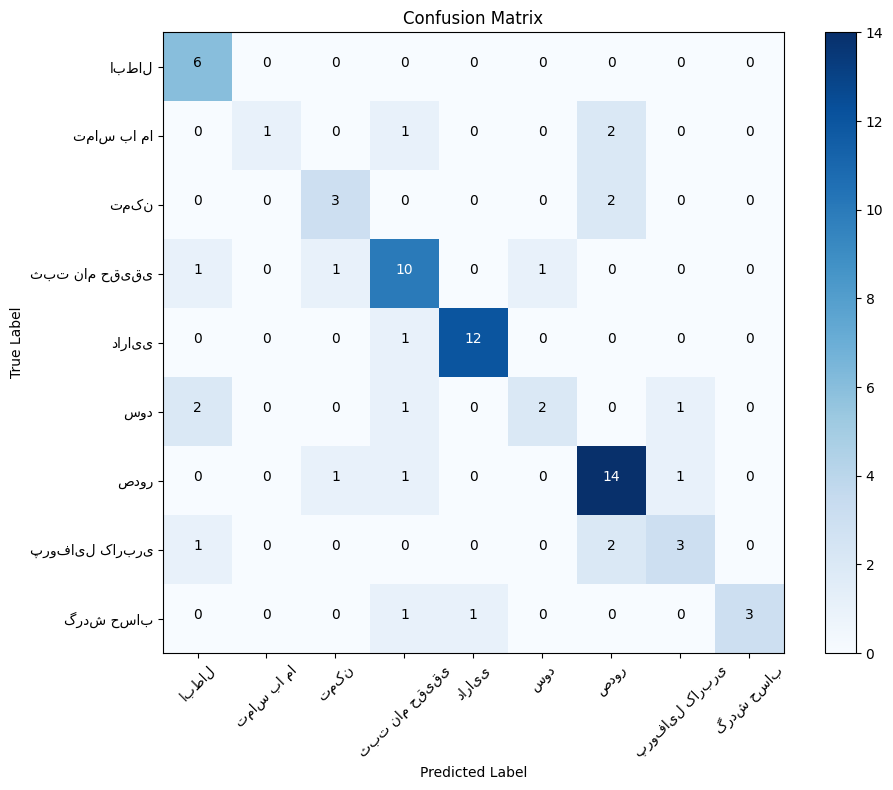

Top features for class 'ابطال': ['واریز می' 'مشترک' 'مبلغ' 'را نریختید' 'نریختید']
Top features for class 'تماس با ما': ['سقف' 'بالا' 'چرا' 'سقف صدور' 'سقف واریز']
Top features for class 'تمکن': ['نرخ' 'را به' 'تعداد واحد' 'ابطال را' 'ابطال']
Top features for class 'ثبت نام حقیقی': ['محاسبه سود' 'حقیقی' 'توضیح ابطال' 'ابطال چیست' 'بعد']
Top features for class 'دارایی': ['چه روزی' 'روزی' 'ابطال' 'کدام روز' 'میگردد']
Top features for class 'سود': ['حساب پارسیان' 'چقدر' 'ماه' 'در یک' 'یک']
Top features for class 'صدور': ['نحوه ابطال' 'چگونه است' 'میشه' 'لوتوس چگونه' 'میریزید']
Top features for class 'پروفایل کاربری': ['آیا' 'شمار' 'خطا' 'شمار است' 'بمونه']
Top features for class 'گردش حساب': ['دارد' 'دریافت' 'صدور' 'هزینه' 'میتوانم']


In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# ---------------------------
# 1. Data Loading and Cleaning
# ---------------------------
# Load the data from CSV
data = pd.read_csv('/content/faq_data.csv')

# Define a text cleaning function: lowercase, punctuation removal, whitespace normalization
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the cleaning function
data['question_clean'] = data['question'].apply(clean_text)

# ---------------------------
# 2. Label Encoding and Data Splitting
# ---------------------------
# Encode the target labels (button)
le = LabelEncoder()
y = le.fit_transform(data['button'])

# Split the dataset into training and test sets using the cleaned question text
X_train_text, X_test_text, y_train, y_test = train_test_split(
    data['question_clean'], y, test_size=0.2, random_state=42
)

# ---------------------------
# 3. Pipeline Creation and Hyperparameter Tuning
# ---------------------------
# Build a pipeline that includes TF-IDF vectorization and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# Set up the parameter grid: test different n-gram ranges and regularization strengths
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams vs. Unigrams + Bigrams
    'clf__C': [0.01, 0.1, 1, 10, 100]         # Regularization strength
}

# Run grid search with 5-fold cross-validation
grid_search_pipe = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search_pipe.fit(X_train_text, y_train)

print("Best parameters:", grid_search_pipe.best_params_)
print("Best cross-validation accuracy:", grid_search_pipe.best_score_)

# ---------------------------
# 4. Model Evaluation on Test Set
# ---------------------------
# Predict on the test set using the best estimator
y_pred_pipe = grid_search_pipe.predict(X_test_text)

print("\nTest set accuracy:", accuracy_score(y_test, y_pred_pipe))
print("Classification Report on Test Set:\n",
      classification_report(y_test, y_pred_pipe, target_names=le.classes_))

# ---------------------------
# 5. Confusion Matrix Visualization (using matplotlib)
# ---------------------------
cm = confusion_matrix(y_test, y_pred_pipe)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

# Annotate each cell with the count
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ---------------------------
# 6. Feature Importance Analysis: Top Features for Each Class
# ---------------------------
# Retrieve the best TF-IDF vectorizer and classifier from the pipeline
best_vectorizer = grid_search_pipe.best_estimator_.named_steps['tfidf']
best_clf = grid_search_pipe.best_estimator_.named_steps['clf']

feature_names = best_vectorizer.get_feature_names_out()
coef = best_clf.coef_

# For each class, display the top 5 features (tokens) based on model coefficients
for i, class_label in enumerate(le.classes_):
    top_n = 5
    top_feature_indices = np.argsort(coef[i])[-top_n:][::-1]
    top_features = feature_names[top_feature_indices]
    print(f"Top features for class '{class_label}': {top_features}")


In [ ]:
!pip install hazm

In [ ]:
import pandas as pd
import torch
from hazm import Normalizer, word_tokenize, stopwords_list
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)


# ------------------------------
# 1) Load and Inspect the Dataset
# ------------------------------
df = pd.read_csv("/content/faq_data.csv")  # columns: [question, button]
print("Data sample:")
print(df.head(), "\n")

# Example row:
# question: "چطور می‌توانم حسابم را ابطال کنم؟"
# button:   "ابطال"


# -------------------------
# 2) Preprocess Persian Text
# -------------------------
normalizer = Normalizer()
stopwords = set(stopwords_list())

def clean_persian_text(text: str) -> str:
    # 1. Normalize (fix Arabic/Persian characters, remove extra spaces, etc.)
    text = normalizer.normalize(text)
    # 2. Tokenize
    tokens = word_tokenize(text)
    # 3. Optional: remove stop words
    tokens = [t for t in tokens if t not in stopwords]
    # 4. Remove short or non-alphanumeric tokens, if desired
    tokens = [t for t in tokens if len(t) > 1 and t.isalnum()]
    # 5. Rejoin
    return " ".join(tokens)

df["clean_text"] = df["question"].apply(clean_persian_text)
print("Cleaned text sample:")
print(df["clean_text"].head(), "\n")


# ------------------------
# 3) Encode the Labels
# ------------------------
# Convert string labels in 'button' to numeric IDs
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["button"])
num_labels = len(le.classes_)

# For reference, let's see the mapping:
# e.g., {'ثبت نام حقیقی': 0, 'ابطال': 1, ...}
label2id = {label: i for i, label in enumerate(le.classes_)}
id2label = {v: k for k, v in label2id.items()}
print("Label to ID mapping:", label2id, "\n")


# ------------------------
# 4) Train-Test Split
# ------------------------
train_df, eval_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"]
)

train_texts = train_df["clean_text"].tolist()
train_labels = train_df["label_id"].tolist()

eval_texts = eval_df["clean_text"].tolist()
eval_labels = eval_df["label_id"].tolist()

print(f"Train set size: {len(train_texts)}")
print(f"Eval set size:  {len(eval_texts)}\n")


# ------------------------------------------
# 5) Load a Persian BERT Model & Tokenizer
# ------------------------------------------
model_name = "HooshvareLab/bert-fa-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels  # set the number of classes
)
# This model is now ready for single-label classification


# -----------------------------
# 6) Create a Dataset Class
# -----------------------------
# We'll create a custom PyTorch Dataset for train & eval so we can use
# the Hugging Face Trainer API.

class PersianDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        # We'll return a dictionary that the Trainer can consume
        item = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


train_dataset = PersianDataset(train_texts, train_labels, tokenizer)
eval_dataset = PersianDataset(eval_texts, eval_labels, tokenizer)


# ------------------------------------
# 7) Define Training Arguments & Trainer
# ------------------------------------
training_args = TrainingArguments(
    output_dir="persian_bert_model",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",   # evaluate at end of each epoch
    save_strategy="epoch",         # save checkpoint at end of each epoch
    logging_dir="logs",
    logging_steps=10,              # adjust for your data size
    load_best_model_at_end=False,  # can set True if you want to track best
    metric_for_best_model="accuracy",
    # you can also specify a small warmup_ratio or weight_decay, etc.
)


def compute_metrics(eval_pred):
    """
    A function to compute metrics during evaluation.
    For single-label classification, we can calculate accuracy (and others).
    """
    from sklearn.metrics import accuracy_score, f1_score
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1_macro": f1_macro}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


# ------------------
# 8) Train the Model
# ------------------
trainer.train()


# -------------------------------------
# 9) Evaluate on the Evaluation Set
# -------------------------------------
eval_results = trainer.evaluate()
print("\nEvaluation results:", eval_results)


# ---------------------------------------------------
# 10) Save the Fine-Tuned Model and Tokenizer
# ---------------------------------------------------
trainer.save_model("persian_bert_model")      # includes config & pytorch_model.bin
tokenizer.save_pretrained("persian_bert_model")

# Also save the label encoder for later usage
import joblib
joblib.dump(le, "persian_label_encoder.pkl")

print("\nModel, tokenizer, and label encoder saved.")


# ----------------------------------------------------------
# 11) Inference on New Data (Single-Label Classification)
# ----------------------------------------------------------
def predict_button(question_text):
    # 1) Load artifacts
    loaded_tokenizer = AutoTokenizer.from_pretrained("persian_bert_model")
    loaded_model = AutoModelForSequenceClassification.from_pretrained("persian_bert_model")
    loaded_le = joblib.load("persian_label_encoder.pkl")

    # 2) Preprocess the input question
    question_text_clean = clean_persian_text(question_text)

    # 3) Tokenize
    encoding = loaded_tokenizer(
        question_text_clean,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    )

    # 4) Inference
    with torch.no_grad():
        outputs = loaded_model(**encoding)
        logits = outputs.logits  # shape: [batch_size=1, num_labels]
        predicted_class_id = logits.argmax(dim=-1).item()

    # 5) Convert numeric ID back to label
    predicted_label = loaded_le.inverse_transform([predicted_class_id])[0]
    return predicted_label

# Example usage
new_question = "چطور می‌توانم حسابم را ابطال کنم؟"
predicted_btn = predict_button(new_question)
print(f"\nNew question: {new_question}\nPredicted button: {predicted_btn}")


Data sample:
                                      question          button
0                              ذخیره ارزش چیست       گردش حساب
1  آیا محاسبه  سود صندوق به صورت روز شمار است؟  پروفایل کاربری
2      مفهوم FIFO در صندوق لوتوس پارسیان چیست؟      تماس با ما
3                         منظور از ابطال چیست؟   ثبت نام حقیقی
4    در یک روز، سقف ابطال در صندوق چه‌قدر است؟             سود 

Cleaned text sample:
0                        ذخیره ارزش چیست
1              محاسبه سود صندوق صورت روز
2    مفهوم FIFO صندوق لوتوس پارسیان چیست
3                             ابطال چیست
4                    روز سقف ابطال صندوق
Name: clean_text, dtype: object 

Label to ID mapping: {'ابطال': 0, 'تماس با ما': 1, 'تمکن': 2, 'ثبت نام حقیقی': 3, 'دارایی': 4, 'سود': 5, 'صدور': 6, 'پروفایل کاربری': 7, 'گردش حساب': 8} 

Train set size: 299
Eval set size:  75



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-cb6ccc155468>:170: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: msghik (msghik-Apple) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.875400,1.552984,0.466667,0.236491
2,1.340800,1.164971,0.706667,0.574891
3,0.980800,1.045792,0.706667,0.609846



Evaluation results: {'eval_loss': 1.0457916259765625, 'eval_accuracy': 0.7066666666666667, 'eval_f1_macro': 0.6098463496959737, 'eval_runtime': 0.5558, 'eval_samples_per_second': 134.942, 'eval_steps_per_second': 17.992, 'epoch': 3.0}

Model, tokenizer, and label encoder saved.

New question: چطور می‌توانم حسابم را ابطال کنم؟
Predicted button: صدور
